# **Garbage Classification Using Transfer Learning**

## **Import Libraries & Data**

In [37]:
# libraries

import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mps
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [14]:
# data

from google.colab import drive
import zipfile

drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/garbage_data.zip'
extract_path = '/content/garbage_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **EDA**

In [15]:
# total class

category = os.listdir('/content/garbage_data')
category

['plastic', 'glass', 'metal', 'paper', 'cardboard', 'trash']

In [16]:
type(category)

list

In [20]:
# img per category

data_class = {}

for c in category:
  count = len(os.listdir((os.path.join(extract_path, c))))  #  '/content/garbage_data/plastic'
  print(f'{c}: {count}')
  data_class[c] = count

plastic: 482
glass: 501
metal: 410
paper: 594
cardboard: 403
trash: 137


In [21]:
data_class

{'plastic': 482,
 'glass': 501,
 'metal': 410,
 'paper': 594,
 'cardboard': 403,
 'trash': 137}

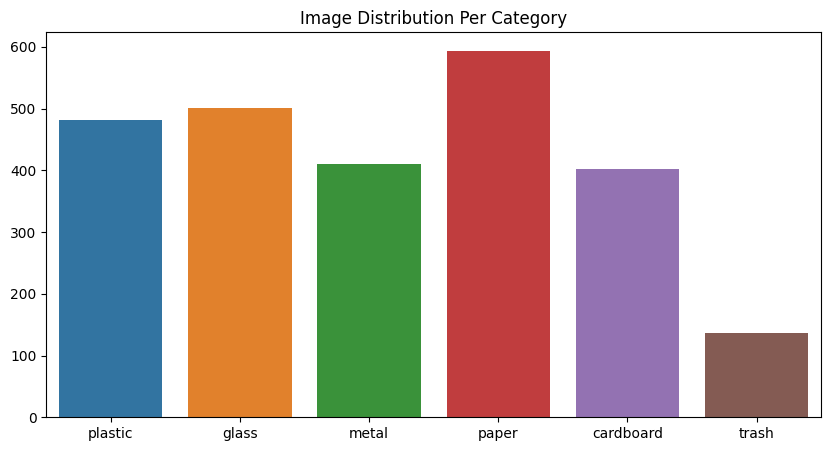

In [28]:
# img per class

plt.figure(figsize=(10, 5))
sns.barplot(x=data_class.keys(), y=data_class.values(), hue=data_class.keys(), palette='tab10')   #  '/content/garbage_data/plastic'
plt.title('Image Distribution Per Category')
plt.show()

## **Data Preprocessing**

In [29]:
# preparing the data

image_size = (128, 128)
batch_size = 32

datagen = ImageDataGenerator(
    rescale = 1 / 255.0,
    validation_split = 0.2
)

# train validate split

# training
train_gen = datagen.flow_from_directory(
    extract_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training',
    shuffle = True
)

# validation
val_gen = datagen.flow_from_directory(
    extract_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation',
    shuffle = True
)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


## **Model Building CNN with Transfer Learning**

In [35]:
# cnn base model

base = MobileNetV2(weights='imagenet', include_top = False, input_shape=(128, 128, 3))
base.trainable = False

# custom layers

x = base.output
x = GlobalAveragePooling2D()(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(6, activation='softmax')(x)

# final model
model = Model(inputs=base.input, outputs=output)

# configuration
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,278,582 (8.69 MB)

 Trainable params: 20,598 (80.46 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [36]:
# model training

history = model.fit(train_gen, validation_data=val_gen, epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 57s 763ms/step - accuracy: 0.3011 - loss: 1.7026 - val_accuracy: 0.5646 - val_loss: 1.1478
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 601ms/step - accuracy: 0.6045 - loss: 1.0597 - val_accuracy: 0.6402 - val_loss: 0.9362
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 635ms/step - accuracy: 0.6737 - loss: 0.9016 - val_accuracy: 0.6839 - val_loss: 0.8346
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 639ms/step - accuracy: 0.7483 - loss: 0.6910 - val_accuracy: 0.7097 - val_loss: 0.8064
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 647ms/step - accuracy: 0.7652 - loss: 0.6273 - val_accuracy: 0.7276 - val_loss: 0.7947
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 560ms/step - accuracy: 0.7922 - loss: 0.5645 - val_accuracy: 0.7217 - val_loss: 0.7514
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 640ms/step - accuracy: 0.8095 - loss: 0.5316 - val_accuracy: 0.7237 - val_loss: 0.7704
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 829ms/step - accuracy: 0.8233 - loss: 0.4679 - val_accu

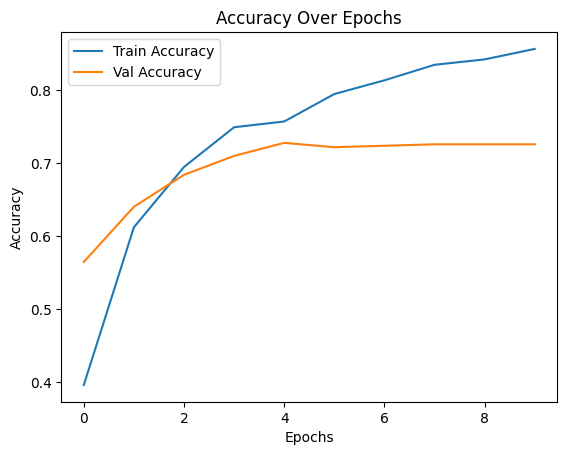

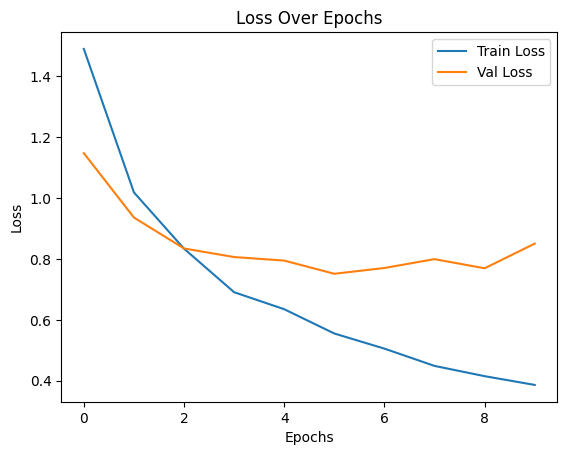

In [39]:
# accuracy and loss curves

# accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 545ms/step


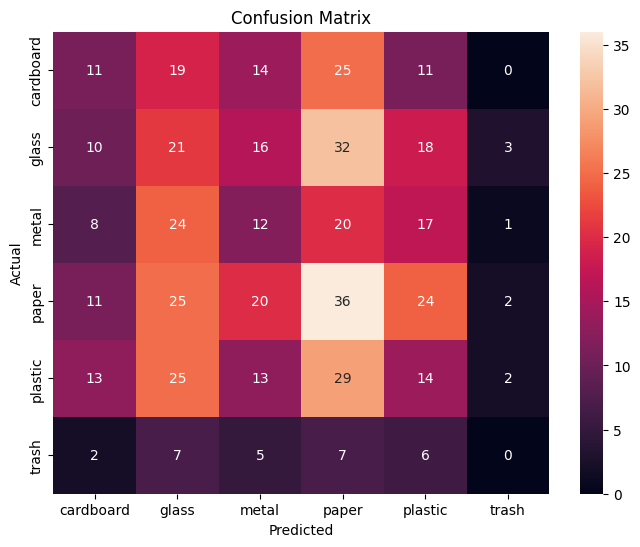

              precision    recall  f1-score   support

   cardboard       0.20      0.14      0.16        80
       glass       0.17      0.21      0.19       100
       metal       0.15      0.15      0.15        82
       paper       0.24      0.31      0.27       118
     plastic       0.16      0.15      0.15        96
       trash       0.00      0.00      0.00        27

    accuracy                           0.19       503
   macro avg       0.15      0.16      0.15       503
weighted avg       0.18      0.19      0.18       503



In [41]:
# Evaluate on Validation Data (Confusion Matrix)

# Predict class probabilities
val_gen.reset()
pred_probs = model.predict(val_gen)

# Convert to class labels
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_gen.classes

# Class labels
labels = list(val_gen.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=labels))